In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simplified Attention Block with reduced dimensions
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__().__init__()
        
        # Reduce intermediate channels to save memory and computation
        F_int = F_int // 2
        
        # Add dropout to prevent overfitting
        self.dropout = nn.Dropout2d(p=0.2)
        
        # Simplified attention mechanism
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
        # Warmup parameter
        self.attention_scale = nn.Parameter(torch.tensor(0.0))

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        psi = self.dropout(psi)  # Apply dropout
        psi = self.psi(psi)
        
        # Gradually introduce attention using the learnable scale parameter
        attention = torch.sigmoid(self.attention_scale) * psi
        
        return x * attention

# Modified Convolutional Block with dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=0.1)  # Add dropout
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout(out)  # Apply dropout
        return out

# Modified Residual Block with dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=0.1)  # Add dropout
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Apply dropout
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)  # Apply dropout
        out += residual
        out = F.relu(out)
        return out

# Modified AttentionResUNet
class ImprovedAttentionResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(ImprovedAttentionResUNet, self).__init__()
        
        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = ConvBlock(512, 1024)
        
        # Decoder with simplified attention
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = ResidualBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = ConvBlock(128, 64)
        
        # Output
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        
        # Bridge
        b = self.bridge(self.pool4(e4))
        
        # Decoder
        d4_up = self.up4(b)
        e4_att = self.att4(d4_up, e4)
        d4 = torch.cat((e4_att, d4_up), dim=1)
        d4 = self.dec4(d4)
        
        d3_up = self.up3(d4)
        e3_att = self.att3(d3_up, e3)
        d3 = torch.cat((e3_att, d3_up), dim=1)
        d3 = self.dec3(d3)
        
        d2_up = self.up2(d3)
        e2_att = self.att2(d2_up, e2)
        d2 = torch.cat((e2_att, d2_up), dim=1)
        d2 = self.dec2(d2)
        
        d1_up = self.up1(d2)
        e1_att = self.att1(d1_up, e1)
        d1 = torch.cat((e1_att, d1_up), dim=1)
        d1 = self.dec1(d1)
        
        return self.final(d1)

Using device: cuda
Loading data...


100%|██████████| 110/110 [00:07<00:00, 15.31it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.51it/s]


Epoch 1/100 - Train Loss: 0.4871, Train Dice Loss: 0.9745, Val Loss: 0.4593, Val Dice Loss: 0.9669
Saved best model with validation loss: 0.4593


Epoch 2/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.47it/s]


Epoch 2/100 - Train Loss: 0.4466, Train Dice Loss: 0.9662, Val Loss: 0.4342, Val Dice Loss: 0.9633
Saved best model with validation loss: 0.4342


Epoch 3/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.49it/s]


Epoch 3/100 - Train Loss: 0.4302, Train Dice Loss: 0.9557, Val Loss: 0.4182, Val Dice Loss: 0.9430
Saved best model with validation loss: 0.4182


Epoch 4/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.50it/s]


Epoch 4/100 - Train Loss: 0.4156, Train Dice Loss: 0.9410, Val Loss: 0.4032, Val Dice Loss: 0.9308
Saved best model with validation loss: 0.4032


Epoch 5/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.49it/s]


Epoch 5/100 - Train Loss: 0.4013, Train Dice Loss: 0.9208, Val Loss: 0.3949, Val Dice Loss: 0.9210
Saved best model with validation loss: 0.3949


Epoch 6/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.53it/s]


Epoch 6/100 - Train Loss: 0.3846, Train Dice Loss: 0.8920, Val Loss: 0.3696, Val Dice Loss: 0.8744
Saved best model with validation loss: 0.3696


Epoch 7/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.26it/s]


Epoch 7/100 - Train Loss: 0.3633, Train Dice Loss: 0.8489, Val Loss: 0.3589, Val Dice Loss: 0.8365
Saved best model with validation loss: 0.3589


Epoch 8/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.67it/s]


Epoch 8/100 - Train Loss: 0.3380, Train Dice Loss: 0.7914, Val Loss: 0.3141, Val Dice Loss: 0.7375
Saved best model with validation loss: 0.3141


Epoch 9/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.47it/s]


Epoch 9/100 - Train Loss: 0.3051, Train Dice Loss: 0.7134, Val Loss: 0.2828, Val Dice Loss: 0.6680
Saved best model with validation loss: 0.2828


Epoch 10/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 10/100 - Train Loss: 0.2796, Train Dice Loss: 0.6510, Val Loss: 0.2723, Val Dice Loss: 0.6407
Saved best model with validation loss: 0.2723


Epoch 11/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 11/100 - Train Loss: 0.2482, Train Dice Loss: 0.5748, Val Loss: 0.2191, Val Dice Loss: 0.5128
Saved best model with validation loss: 0.2191


Epoch 12/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 12/100 - Train Loss: 0.2202, Train Dice Loss: 0.5067, Val Loss: 0.2230, Val Dice Loss: 0.5207
EarlyStopping counter: 1 out of 15


Epoch 13/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.59it/s]


Epoch 13/100 - Train Loss: 0.2084, Train Dice Loss: 0.4755, Val Loss: 0.2174, Val Dice Loss: 0.5005
Saved best model with validation loss: 0.2174


Epoch 14/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.56it/s]


Epoch 14/100 - Train Loss: 0.1920, Train Dice Loss: 0.4359, Val Loss: 0.1814, Val Dice Loss: 0.4099
Saved best model with validation loss: 0.1814


Epoch 15/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 15/100 - Train Loss: 0.1795, Train Dice Loss: 0.4061, Val Loss: 0.1801, Val Dice Loss: 0.4143
Saved best model with validation loss: 0.1801


Epoch 16/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 16/100 - Train Loss: 0.1747, Train Dice Loss: 0.3932, Val Loss: 0.1796, Val Dice Loss: 0.4099
Saved best model with validation loss: 0.1796


Epoch 17/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 17/100 - Train Loss: 0.1633, Train Dice Loss: 0.3665, Val Loss: 0.1487, Val Dice Loss: 0.3379
Saved best model with validation loss: 0.1487


Epoch 18/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.56it/s]


Epoch 18/100 - Train Loss: 0.1634, Train Dice Loss: 0.3665, Val Loss: 0.1428, Val Dice Loss: 0.3265
Saved best model with validation loss: 0.1428


Epoch 19/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 19/100 - Train Loss: 0.1559, Train Dice Loss: 0.3491, Val Loss: 0.1470, Val Dice Loss: 0.3336
EarlyStopping counter: 1 out of 15


Epoch 20/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 20/100 - Train Loss: 0.1399, Train Dice Loss: 0.3126, Val Loss: 0.1540, Val Dice Loss: 0.3458
EarlyStopping counter: 2 out of 15


Epoch 21/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.59it/s]


Epoch 21/100 - Train Loss: 0.1526, Train Dice Loss: 0.3421, Val Loss: 0.1436, Val Dice Loss: 0.3273
EarlyStopping counter: 3 out of 15


Epoch 22/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 22/100 - Train Loss: 0.1378, Train Dice Loss: 0.3063, Val Loss: 0.1384, Val Dice Loss: 0.3180
Saved best model with validation loss: 0.1384


Epoch 23/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.51it/s]


Epoch 23/100 - Train Loss: 0.1371, Train Dice Loss: 0.3061, Val Loss: 0.1466, Val Dice Loss: 0.3343
EarlyStopping counter: 1 out of 15


Epoch 24/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.65it/s]


Epoch 24/100 - Train Loss: 0.1357, Train Dice Loss: 0.3022, Val Loss: 0.1322, Val Dice Loss: 0.3033
Saved best model with validation loss: 0.1322


Epoch 25/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 25/100 - Train Loss: 0.1336, Train Dice Loss: 0.2969, Val Loss: 0.1502, Val Dice Loss: 0.3416
EarlyStopping counter: 1 out of 15


Epoch 26/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 26/100 - Train Loss: 0.1300, Train Dice Loss: 0.2892, Val Loss: 0.1238, Val Dice Loss: 0.2812
Saved best model with validation loss: 0.1238


Epoch 27/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 27/100 - Train Loss: 0.1254, Train Dice Loss: 0.2798, Val Loss: 0.1313, Val Dice Loss: 0.2997
EarlyStopping counter: 1 out of 15


Epoch 28/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 28/100 - Train Loss: 0.1237, Train Dice Loss: 0.2754, Val Loss: 0.1250, Val Dice Loss: 0.2851
EarlyStopping counter: 2 out of 15


Epoch 29/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 29/100 - Train Loss: 0.1285, Train Dice Loss: 0.2858, Val Loss: 0.1273, Val Dice Loss: 0.2883
EarlyStopping counter: 3 out of 15


Epoch 30/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 30/100 - Train Loss: 0.1231, Train Dice Loss: 0.2736, Val Loss: 0.1201, Val Dice Loss: 0.2707
Saved best model with validation loss: 0.1201


Epoch 31/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.56it/s]


Epoch 31/100 - Train Loss: 0.1220, Train Dice Loss: 0.2716, Val Loss: 0.1404, Val Dice Loss: 0.3168
EarlyStopping counter: 1 out of 15


Epoch 32/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 32/100 - Train Loss: 0.1248, Train Dice Loss: 0.2755, Val Loss: 0.1259, Val Dice Loss: 0.2825
EarlyStopping counter: 2 out of 15


Epoch 33/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 33/100 - Train Loss: 0.1161, Train Dice Loss: 0.2579, Val Loss: 0.1162, Val Dice Loss: 0.2655
Saved best model with validation loss: 0.1162


Epoch 34/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.53it/s]


Epoch 34/100 - Train Loss: 0.1158, Train Dice Loss: 0.2578, Val Loss: 0.1150, Val Dice Loss: 0.2630
Saved best model with validation loss: 0.1150


Epoch 35/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 35/100 - Train Loss: 0.1165, Train Dice Loss: 0.2577, Val Loss: 0.1220, Val Dice Loss: 0.2752
EarlyStopping counter: 1 out of 15


Epoch 36/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 36/100 - Train Loss: 0.1077, Train Dice Loss: 0.2395, Val Loss: 0.1189, Val Dice Loss: 0.2701
EarlyStopping counter: 2 out of 15


Epoch 37/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 37/100 - Train Loss: 0.1094, Train Dice Loss: 0.2420, Val Loss: 0.1163, Val Dice Loss: 0.2650
EarlyStopping counter: 3 out of 15


Epoch 38/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 38/100 - Train Loss: 0.1103, Train Dice Loss: 0.2451, Val Loss: 0.1131, Val Dice Loss: 0.2533
Saved best model with validation loss: 0.1131


Epoch 39/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 39/100 - Train Loss: 0.1097, Train Dice Loss: 0.2433, Val Loss: 0.1037, Val Dice Loss: 0.2336
Saved best model with validation loss: 0.1037


Epoch 40/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 40/100 - Train Loss: 0.1120, Train Dice Loss: 0.2486, Val Loss: 0.1084, Val Dice Loss: 0.2443
EarlyStopping counter: 1 out of 15


Epoch 41/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 41/100 - Train Loss: 0.1061, Train Dice Loss: 0.2358, Val Loss: 0.1092, Val Dice Loss: 0.2488
EarlyStopping counter: 2 out of 15


Epoch 42/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 42/100 - Train Loss: 0.1081, Train Dice Loss: 0.2406, Val Loss: 0.1118, Val Dice Loss: 0.2540
EarlyStopping counter: 3 out of 15


Epoch 43/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 43/100 - Train Loss: 0.1129, Train Dice Loss: 0.2511, Val Loss: 0.0969, Val Dice Loss: 0.2200
Saved best model with validation loss: 0.0969


Epoch 44/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 44/100 - Train Loss: 0.0958, Train Dice Loss: 0.2112, Val Loss: 0.1099, Val Dice Loss: 0.2491
EarlyStopping counter: 1 out of 15


Epoch 45/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 45/100 - Train Loss: 0.1002, Train Dice Loss: 0.2225, Val Loss: 0.1085, Val Dice Loss: 0.2470
EarlyStopping counter: 2 out of 15


Epoch 46/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.53it/s]


Epoch 46/100 - Train Loss: 0.1046, Train Dice Loss: 0.2324, Val Loss: 0.1094, Val Dice Loss: 0.2502
EarlyStopping counter: 3 out of 15


Epoch 47/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 47/100 - Train Loss: 0.0997, Train Dice Loss: 0.2209, Val Loss: 0.0977, Val Dice Loss: 0.2204
EarlyStopping counter: 4 out of 15


Epoch 48/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.64it/s]


Epoch 48/100 - Train Loss: 0.1080, Train Dice Loss: 0.2390, Val Loss: 0.1056, Val Dice Loss: 0.2368
EarlyStopping counter: 5 out of 15


Epoch 49/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 49/100 - Train Loss: 0.0975, Train Dice Loss: 0.2160, Val Loss: 0.1000, Val Dice Loss: 0.2256
EarlyStopping counter: 6 out of 15


Epoch 50/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.61it/s]


Epoch 50/100 - Train Loss: 0.0916, Train Dice Loss: 0.2032, Val Loss: 0.0966, Val Dice Loss: 0.2203
Saved best model with validation loss: 0.0966


Epoch 51/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 51/100 - Train Loss: 0.0908, Train Dice Loss: 0.2009, Val Loss: 0.0979, Val Dice Loss: 0.2204
EarlyStopping counter: 1 out of 15


Epoch 52/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.56it/s]


Epoch 52/100 - Train Loss: 0.0917, Train Dice Loss: 0.2021, Val Loss: 0.0934, Val Dice Loss: 0.2118
Saved best model with validation loss: 0.0934


Epoch 53/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 53/100 - Train Loss: 0.0901, Train Dice Loss: 0.1994, Val Loss: 0.0948, Val Dice Loss: 0.2166
EarlyStopping counter: 1 out of 15


Epoch 54/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 54/100 - Train Loss: 0.0896, Train Dice Loss: 0.1991, Val Loss: 0.0901, Val Dice Loss: 0.2024
Saved best model with validation loss: 0.0901


Epoch 55/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.53it/s]


Epoch 55/100 - Train Loss: 0.0912, Train Dice Loss: 0.2010, Val Loss: 0.0942, Val Dice Loss: 0.2142
EarlyStopping counter: 1 out of 15


Epoch 56/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.56it/s]


Epoch 56/100 - Train Loss: 0.0910, Train Dice Loss: 0.2022, Val Loss: 0.1001, Val Dice Loss: 0.2244
EarlyStopping counter: 2 out of 15


Epoch 57/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.63it/s]


Epoch 57/100 - Train Loss: 0.0982, Train Dice Loss: 0.2183, Val Loss: 0.1022, Val Dice Loss: 0.2303
EarlyStopping counter: 3 out of 15


Epoch 58/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.61it/s]


Epoch 58/100 - Train Loss: 0.0948, Train Dice Loss: 0.2091, Val Loss: 0.0960, Val Dice Loss: 0.2163
EarlyStopping counter: 4 out of 15


Epoch 59/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.59it/s]


Epoch 59/100 - Train Loss: 0.0996, Train Dice Loss: 0.2213, Val Loss: 0.1001, Val Dice Loss: 0.2296
EarlyStopping counter: 5 out of 15


Epoch 60/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 60/100 - Train Loss: 0.0946, Train Dice Loss: 0.2109, Val Loss: 0.1269, Val Dice Loss: 0.2846
EarlyStopping counter: 6 out of 15


Epoch 61/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.59it/s]


Epoch 61/100 - Train Loss: 0.0899, Train Dice Loss: 0.2004, Val Loss: 0.0912, Val Dice Loss: 0.2072
EarlyStopping counter: 7 out of 15


Epoch 62/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.63it/s]


Epoch 62/100 - Train Loss: 0.0875, Train Dice Loss: 0.1954, Val Loss: 0.0894, Val Dice Loss: 0.2017
Saved best model with validation loss: 0.0894


Epoch 63/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 63/100 - Train Loss: 0.0844, Train Dice Loss: 0.1871, Val Loss: 0.0923, Val Dice Loss: 0.2094
EarlyStopping counter: 1 out of 15


Epoch 64/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 64/100 - Train Loss: 0.0835, Train Dice Loss: 0.1850, Val Loss: 0.0993, Val Dice Loss: 0.2244
EarlyStopping counter: 2 out of 15


Epoch 65/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 65/100 - Train Loss: 0.0859, Train Dice Loss: 0.1905, Val Loss: 0.0931, Val Dice Loss: 0.2098
EarlyStopping counter: 3 out of 15


Epoch 66/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 66/100 - Train Loss: 0.0843, Train Dice Loss: 0.1872, Val Loss: 0.0888, Val Dice Loss: 0.2020
Saved best model with validation loss: 0.0888


Epoch 67/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 67/100 - Train Loss: 0.0815, Train Dice Loss: 0.1801, Val Loss: 0.0933, Val Dice Loss: 0.2116
EarlyStopping counter: 1 out of 15


Epoch 68/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.47it/s]


Epoch 68/100 - Train Loss: 0.0883, Train Dice Loss: 0.1959, Val Loss: 0.0892, Val Dice Loss: 0.1985
EarlyStopping counter: 2 out of 15


Epoch 69/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 69/100 - Train Loss: 0.0916, Train Dice Loss: 0.2042, Val Loss: 0.0844, Val Dice Loss: 0.1923
Saved best model with validation loss: 0.0844


Epoch 70/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.56it/s]


Epoch 70/100 - Train Loss: 0.0865, Train Dice Loss: 0.1930, Val Loss: 0.0899, Val Dice Loss: 0.2071
EarlyStopping counter: 1 out of 15


Epoch 71/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.63it/s]


Epoch 71/100 - Train Loss: 0.0812, Train Dice Loss: 0.1802, Val Loss: 0.0863, Val Dice Loss: 0.1965
EarlyStopping counter: 2 out of 15


Epoch 72/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 72/100 - Train Loss: 0.0765, Train Dice Loss: 0.1695, Val Loss: 0.0911, Val Dice Loss: 0.2086
EarlyStopping counter: 3 out of 15


Epoch 73/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.52it/s]


Epoch 73/100 - Train Loss: 0.0787, Train Dice Loss: 0.1740, Val Loss: 0.1102, Val Dice Loss: 0.2460
EarlyStopping counter: 4 out of 15


Epoch 74/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 74/100 - Train Loss: 0.0821, Train Dice Loss: 0.1820, Val Loss: 0.0875, Val Dice Loss: 0.1995
EarlyStopping counter: 5 out of 15


Epoch 75/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 75/100 - Train Loss: 0.0796, Train Dice Loss: 0.1774, Val Loss: 0.0867, Val Dice Loss: 0.1966
EarlyStopping counter: 6 out of 15


Epoch 76/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.62it/s]


Epoch 76/100 - Train Loss: 0.0840, Train Dice Loss: 0.1866, Val Loss: 0.0909, Val Dice Loss: 0.2057
EarlyStopping counter: 7 out of 15


Epoch 77/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.61it/s]


Epoch 77/100 - Train Loss: 0.0769, Train Dice Loss: 0.1700, Val Loss: 0.0815, Val Dice Loss: 0.1860
Saved best model with validation loss: 0.0815


Epoch 78/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 78/100 - Train Loss: 0.0799, Train Dice Loss: 0.1773, Val Loss: 0.0992, Val Dice Loss: 0.2257
EarlyStopping counter: 1 out of 15


Epoch 79/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 79/100 - Train Loss: 0.0745, Train Dice Loss: 0.1649, Val Loss: 0.0959, Val Dice Loss: 0.2154
EarlyStopping counter: 2 out of 15


Epoch 80/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.58it/s]


Epoch 80/100 - Train Loss: 0.0777, Train Dice Loss: 0.1716, Val Loss: 0.0886, Val Dice Loss: 0.1996
EarlyStopping counter: 3 out of 15


Epoch 81/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 81/100 - Train Loss: 0.0751, Train Dice Loss: 0.1666, Val Loss: 0.0834, Val Dice Loss: 0.1881
EarlyStopping counter: 4 out of 15


Epoch 82/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 82/100 - Train Loss: 0.0877, Train Dice Loss: 0.1958, Val Loss: 0.1102, Val Dice Loss: 0.2447
EarlyStopping counter: 5 out of 15


Epoch 83/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 83/100 - Train Loss: 0.0762, Train Dice Loss: 0.1686, Val Loss: 0.0832, Val Dice Loss: 0.1888
EarlyStopping counter: 6 out of 15


Epoch 84/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.53it/s]


Epoch 84/100 - Train Loss: 0.0740, Train Dice Loss: 0.1637, Val Loss: 0.0857, Val Dice Loss: 0.1942
EarlyStopping counter: 7 out of 15


Epoch 85/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.59it/s]


Epoch 85/100 - Train Loss: 0.0738, Train Dice Loss: 0.1642, Val Loss: 0.0844, Val Dice Loss: 0.1901
EarlyStopping counter: 8 out of 15


Epoch 86/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 86/100 - Train Loss: 0.0868, Train Dice Loss: 0.1939, Val Loss: 0.0942, Val Dice Loss: 0.2164
EarlyStopping counter: 9 out of 15


Epoch 87/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.57it/s]


Epoch 87/100 - Train Loss: 0.0837, Train Dice Loss: 0.1844, Val Loss: 0.0909, Val Dice Loss: 0.2070
EarlyStopping counter: 10 out of 15


Epoch 88/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.55it/s]


Epoch 88/100 - Train Loss: 0.0715, Train Dice Loss: 0.1592, Val Loss: 0.0868, Val Dice Loss: 0.1975
EarlyStopping counter: 11 out of 15


Epoch 89/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.54it/s]


Epoch 89/100 - Train Loss: 0.0691, Train Dice Loss: 0.1530, Val Loss: 0.0930, Val Dice Loss: 0.2123
EarlyStopping counter: 12 out of 15


Epoch 90/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.59it/s]


Epoch 90/100 - Train Loss: 0.0689, Train Dice Loss: 0.1527, Val Loss: 0.0851, Val Dice Loss: 0.1913
EarlyStopping counter: 13 out of 15


Epoch 91/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.60it/s]


Epoch 91/100 - Train Loss: 0.0751, Train Dice Loss: 0.1667, Val Loss: 0.0889, Val Dice Loss: 0.2028
EarlyStopping counter: 14 out of 15


Epoch 92/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.51it/s]


Epoch 92/100 - Train Loss: 0.0776, Train Dice Loss: 0.1734, Val Loss: 0.0879, Val Dice Loss: 0.1981
EarlyStopping counter: 15 out of 15
Early stopping triggered


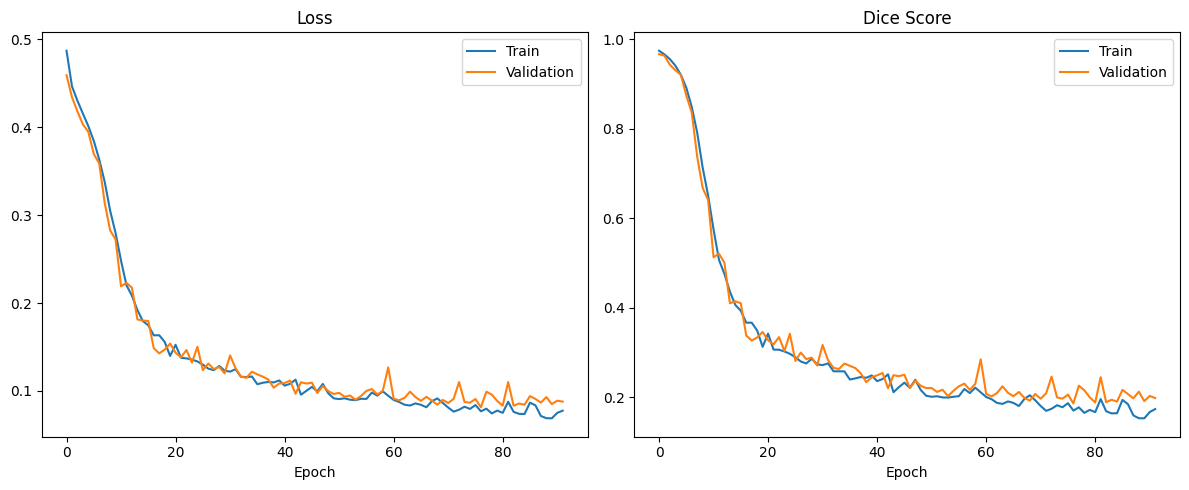

Evaluating: 100%|██████████| 589/589 [00:04<00:00, 140.88it/s]


Test Dice Score: 0.8785


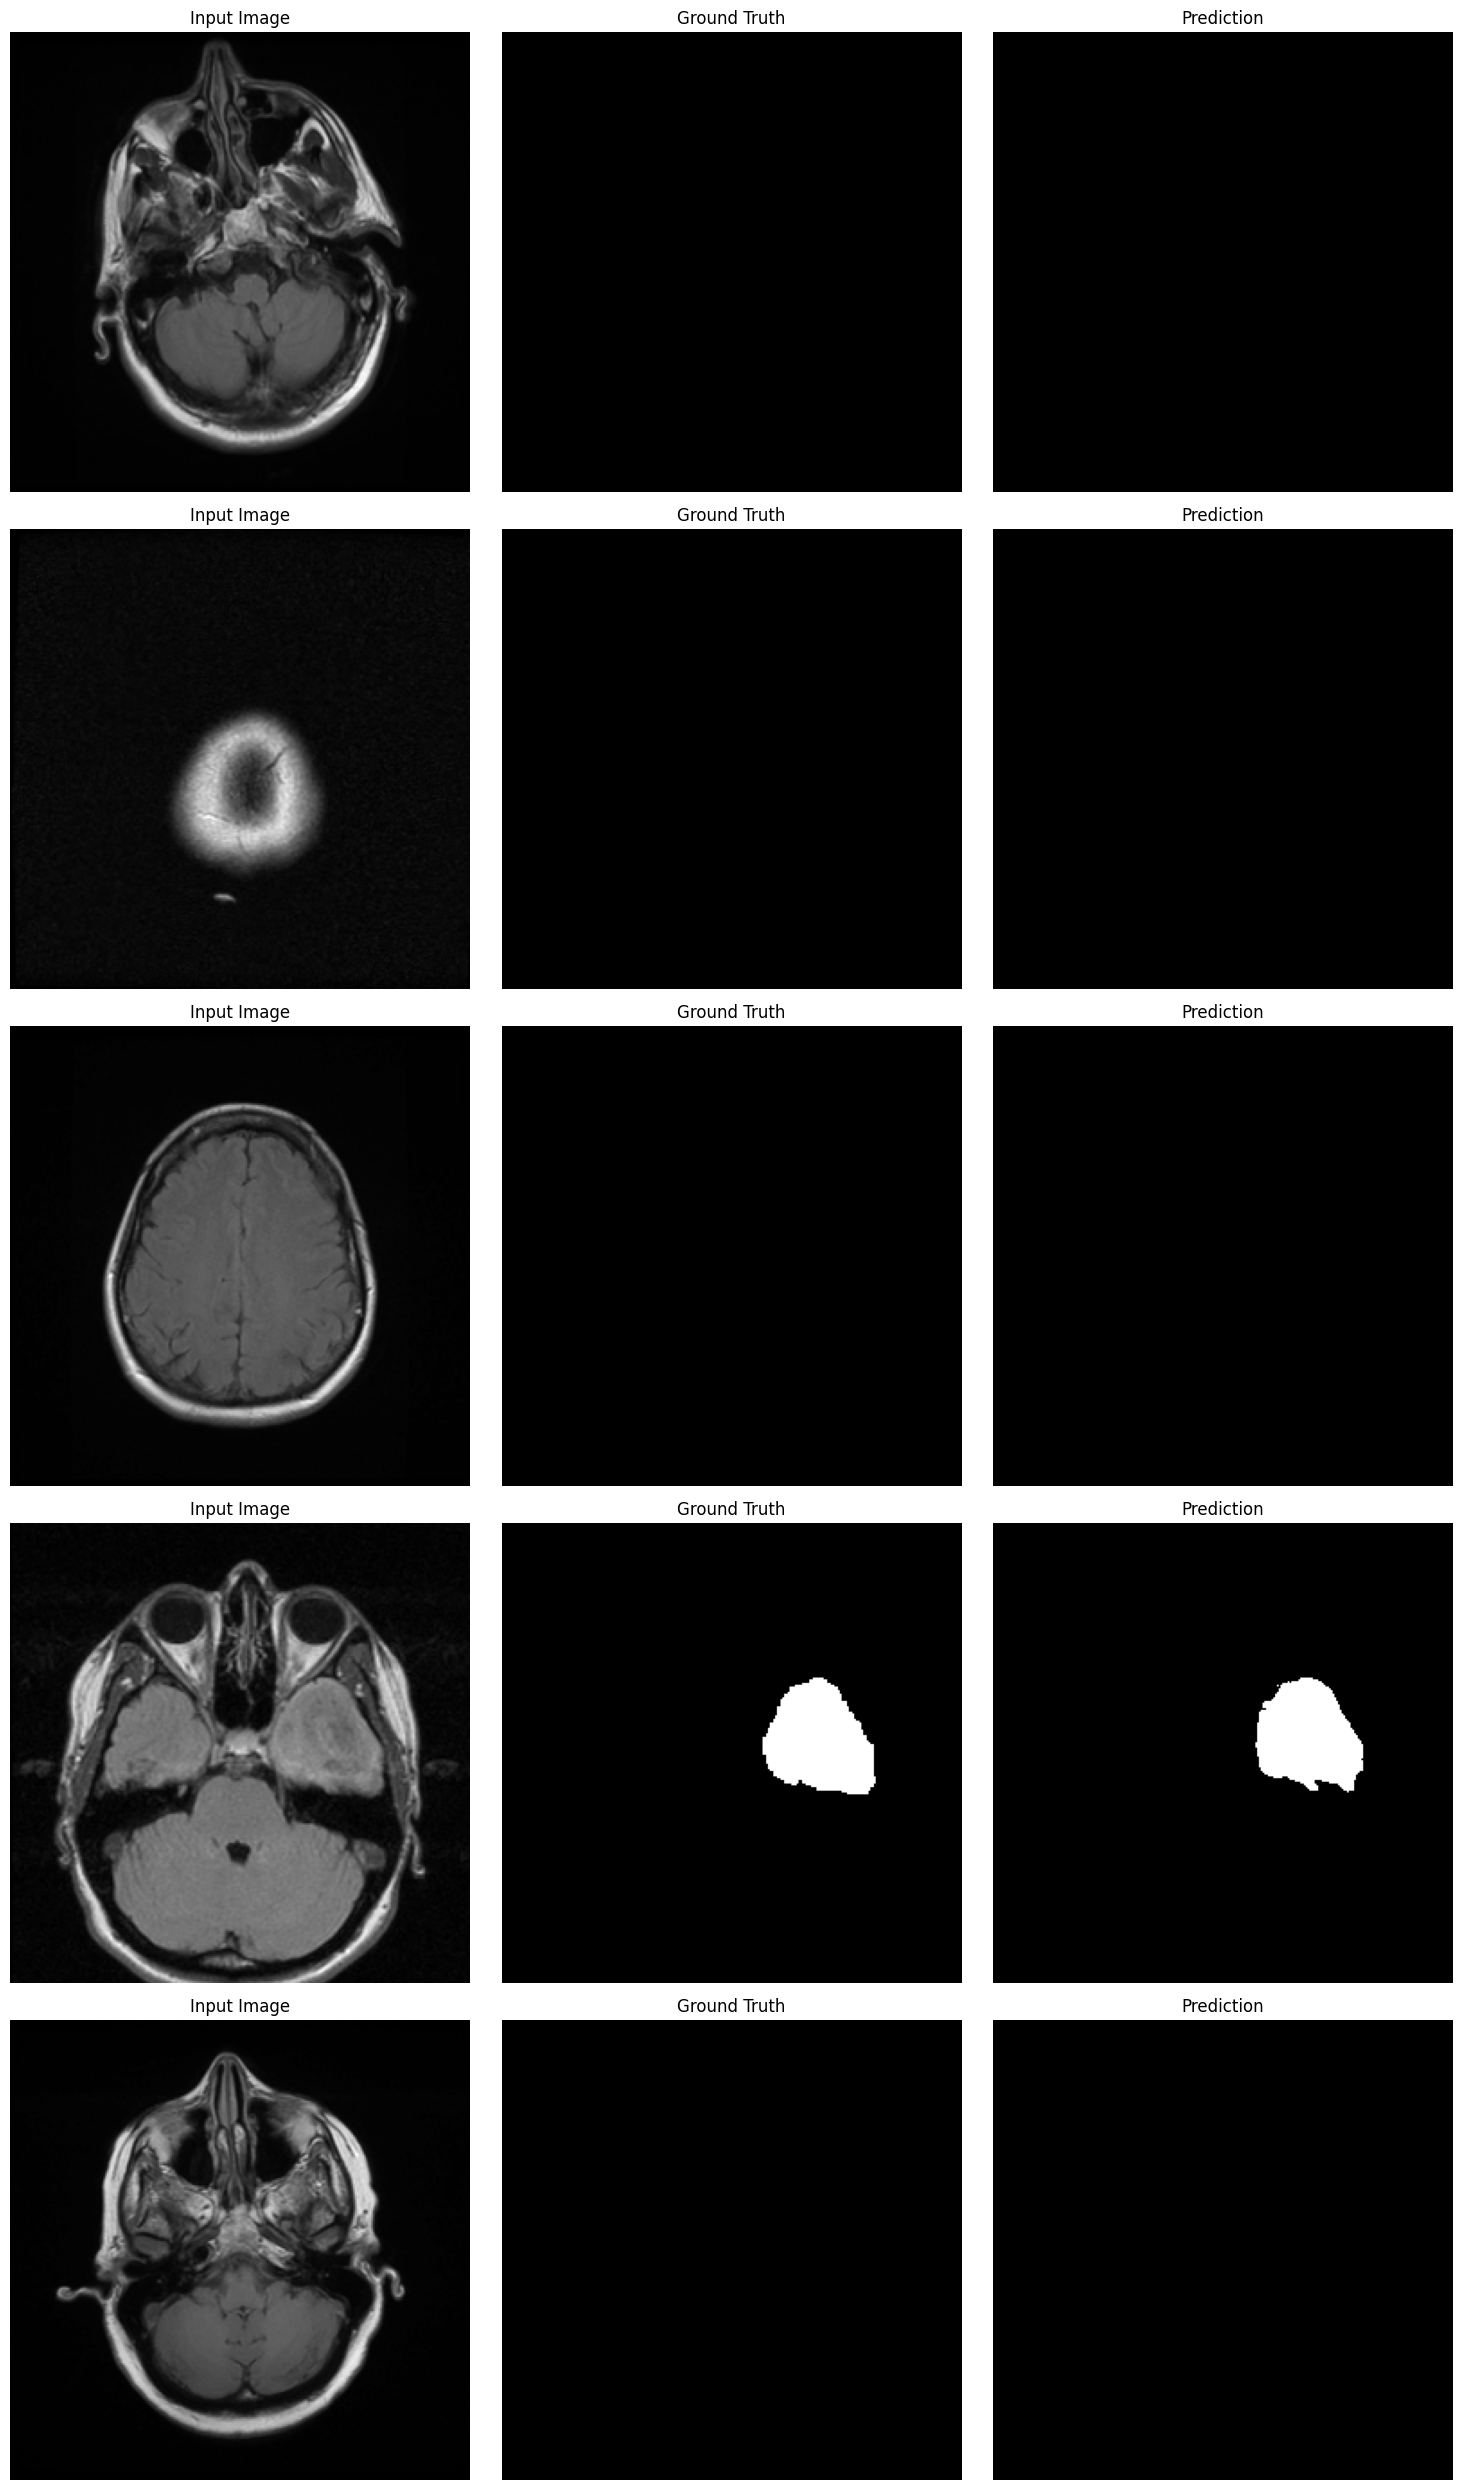

In [2]:
from segmentation import run_segmentation_pipeline

# Create model instance
my_model = ImprovedAttentionResUNet(in_channels=1, out_channels=1)

# Run the pipeline with modified parameters
trained_model, dice_score = run_segmentation_pipeline(
    model=my_model,
    base_dir="kaggle_3m",
    model_name="ImprovedAttresunet",
    batch_size=8,  # Matched with ResUNet
    patience=15,   # Increased patience for better convergence
    epochs=100
)